# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                 
Sample_179  O75326                                            18.730
Sample_108  Q86UD1                                            16.968
Sample_078  O94985-2                                          17.941
Sample_038  F8W8W7;J3KQ45;O43493;O43493-2;O43493-3;O43493-5   16.952
Sample_120  Q86SR1                                            15.292
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups 
Sample_137  Q9H3T2;Q9H3T2-3   14.293
Sample_191  P09960;P09960-4   13.885
Sample_001  Q9BQT9;Q9BQT9-2   18.859
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.193
            A0A075B6Q5                 11.641
            A0A075B6R2                 13.307
            A0A075B6S5                 14.731
            A0A087WSY4                 11.595
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.565
            Q9UI40;Q9UI40-2            12.643
            Q9UIW2                     11.752
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.176
            Q9UP79                     12.585
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.127,15.050,16.842,19.863,15.951,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.909,19.067,...,15.528,15.576,14.222,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.889,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.284,17.705,17.039,16.006,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.709,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.541,15.345,17.084,18.708,14.249,19.433,11.223,11.395
Sample_207,15.739,16.877,15.469,16.898,15.081,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.193,...,16.012,15.178,13.188,15.050,16.842,19.863,12.398,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.607,19.067,16.188,...,15.528,15.576,13.436,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.159,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.837,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.755,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,11.718,15.345,17.084,18.708,14.249,19.433,12.215,11.881
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 413.31it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.83it/s]

100%|██████████| 3/3 [00:00<00:00,  2.90it/s]

100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.52it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.59it/s]

100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.74it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.45it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.30it/s]

100%|██████████| 5/5 [00:01<00:00,  2.45it/s]

100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.50it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.73it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.41it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.47it/s]

100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.49it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.41it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.17it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.07it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.25it/s]

100%|██████████| 7/7 [00:02<00:00,  2.39it/s]

100%|██████████| 7/7 [00:02<00:00,  2.36it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.93it/s]

 38%|███▊      | 3/8 [00:00<00:01,  2.92it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.35it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.98it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.07it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.30it/s]

100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

100%|██████████| 8/8 [00:03<00:00,  2.46it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.56it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.90it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.35it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.11it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.18it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.19it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.28it/s]

100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

100%|██████████| 9/9 [00:03<00:00,  2.42it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.56it/s]

 30%|███       | 3/10 [00:01<00:02,  2.56it/s]

 40%|████      | 4/10 [00:01<00:02,  2.34it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.25it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.22it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.36it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.48it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.49it/s]

100%|██████████| 10/10 [00:03<00:00,  2.56it/s]

100%|██████████| 10/10 [00:03<00:00,  2.51it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.83it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.49it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.01it/s]

 45%|████▌     | 5/11 [00:02<00:03,  1.79it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.61it/s]

 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.80it/s]

 91%|█████████ | 10/11 [00:05<00:00,  1.96it/s]

100%|██████████| 11/11 [00:05<00:00,  2.18it/s]

100%|██████████| 11/11 [00:05<00:00,  1.97it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.15it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.31it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.75it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.44it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.30it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.20it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.15it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.30it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.31it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.22it/s]

100%|██████████| 12/12 [00:05<00:00,  2.07it/s]

100%|██████████| 12/12 [00:05<00:00,  2.37it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.04it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.70it/s]

 31%|███       | 4/13 [00:01<00:04,  2.06it/s]

 38%|███▊      | 5/13 [00:02<00:04,  1.83it/s]

 46%|████▌     | 6/13 [00:03<00:04,  1.70it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.76it/s]

 62%|██████▏   | 8/13 [00:04<00:02,  1.79it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.85it/s]

 77%|███████▋  | 10/13 [00:05<00:01,  1.97it/s]

 85%|████████▍ | 11/13 [00:05<00:00,  2.08it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.21it/s]

100%|██████████| 13/13 [00:06<00:00,  2.29it/s]

100%|██████████| 13/13 [00:06<00:00,  2.08it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.90it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.06it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.66it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.27it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.13it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.17it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.24it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.25it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.35it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.40it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.10it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.07it/s]

100%|██████████| 14/14 [00:06<00:00,  2.12it/s]

100%|██████████| 14/14 [00:06<00:00,  2.32it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.36it/s]

 20%|██        | 3/15 [00:00<00:02,  4.17it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.68it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.00it/s]

 40%|████      | 6/15 [00:02<00:03,  2.41it/s]

 47%|████▋     | 7/15 [00:02<00:04,  1.90it/s]

 53%|█████▎    | 8/15 [00:03<00:04,  1.73it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.63it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.82it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.94it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.99it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.03it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.07it/s]

100%|██████████| 15/15 [00:06<00:00,  2.11it/s]

100%|██████████| 15/15 [00:06<00:00,  2.18it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.046 0.007          0.608 0.434       0.084   
2             0.004 0.000      0.048 0.008          0.716 0.088       0.600   
3             0.004 0.002      0.051 0.012          0.709 0.098       0.594   
4             0.004 0.001      0.051 0.014          0.761 0.105       0.618   
5             0.004 0.002      0.054 0.018          0.746 0.087       0.629   
6             0.004 0.002      0.053 0.015          0.772 0.092       0.764   
7             0.005 0.003      0.056 0.020          0.785 0.091       0.777   
8             0.004 0.002      0.056 0.019          0.782 0.088       0.800   
9             0.004 0.003      0.055 0.016          0.784 0.088       0.804   
10            0.005 0.005      0.054 0.019          0.795 0.096       0.788   
11            0.005 0.004      0.060 0.022          0.809 0.090       0.795   
12            0.006 0.004      0.072 0.028          0.802 0.090       0.795   
13            0.006 0.004      0.066 0.022          0.793 0.097       0.780   
14            0.005 0.002      0.061 0.026          0.790 0.091       0.782   
15            0.004 0.002      0.057 0.019          0.818 0.094       0.795   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.142 0.125                  0.535 0.038        0.845   
2          0.103   0.647 0.079                  0.711 0.057        0.777   
3          0.104   0.640 0.080                  0.705 0.059        0.771   
4          0.117   0.675 0.092                  0.736 0.066        0.783   
5          0.113   0.677 0.084                  0.735 0.060        0.779   
6          0.114   0.762 0.081                  0.798 0.068        0.881   
7          0.107   0.776 0.075                  0.809 0.063        0.879   
8          0.115   0.786 0.082                  0.817 0.069        0.898   
9          0.111   0.789 0.077                  0.819 0.066        0.897   
10         0.119   0.786 0.086                  0.818 0.072        0.894   
11         0.096   0.797 0.069                  0.827 0.058        0.907   
12         0.096   0.794 0.071                  0.824 0.060        0.905   
13         0.101   0.781 0.074                  0.813 0.063        0.902   
14         0.102   0.781 0.073                  0.813 0.061        0.901   
15         0.104   0.801 0.075                  0.831 0.062        0.905   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.822 0.088        210.000 0.000  
2          0.068                  0.758 0.085        210.000 0.000  
3          0.068                  0.752 0.084        210.000 0.000  
4          0.069                  0.761 0.086        210.000 0.000  
5          0.068                  0.757 0.086        210.000 0.000  
6          0.053                  0.854 0.060        210.000 0.000  
7          0.051                  0.852 0.060        210.000 0.000  
8          0.050                  0.888 0.051        210.000 0.000  
9          0.051                  0.887 0.052        210.000 0.000  
10         0.053                  0.882 0.055        210.000 0.000  
11         0.051                  0.901 0.049        210.000 0.000  
12         0.051                  0.898 0.049        210.000 0.000  
13         0.051                  0.895 0.050        210.000 0.000  
14         0.051                  0.892 0.050        210.000 0.000  
15         0.051                  0.893 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 472.60it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.94it/s]

100%|██████████| 3/3 [00:00<00:00,  3.80it/s]

100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.94it/s]

100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.76it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.73it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.49it/s]

100%|██████████| 5/5 [00:01<00:00,  2.45it/s]

100%|██████████| 5/5 [00:01<00:00,  2.60it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.19it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.66it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.37it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.05it/s]

100%|██████████| 6/6 [00:02<00:00,  1.94it/s]

100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.71it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.21it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.10it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.72it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.66it/s]

100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

100%|██████████| 7/7 [00:02<00:00,  2.89it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.06it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.75it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.66it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.49it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.46it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.43it/s]

100%|██████████| 8/8 [00:03<00:00,  2.38it/s]

100%|██████████| 8/8 [00:03<00:00,  2.51it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:02,  3.41it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.52it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.24it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.17it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.08it/s]

 78%|███████▊  | 7/9 [00:03<00:00,  2.21it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.25it/s]

100%|██████████| 9/9 [00:03<00:00,  2.29it/s]

100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.22it/s]

 30%|███       | 3/10 [00:01<00:03,  2.18it/s]

 40%|████      | 4/10 [00:01<00:02,  2.12it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.21it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.10it/s]

 70%|███████   | 7/10 [00:03<00:01,  2.16it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.22it/s]

 90%|█████████ | 9/10 [00:04<00:00,  2.20it/s]

100%|██████████| 10/10 [00:04<00:00,  2.19it/s]

100%|██████████| 10/10 [00:04<00:00,  2.22it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.35it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.46it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.25it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.31it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.34it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.40it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.37it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.35it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.83it/s]

100%|██████████| 11/11 [00:05<00:00,  1.63it/s]

100%|██████████| 11/11 [00:05<00:00,  2.05it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:03,  2.84it/s]

 25%|██▌       | 3/12 [00:01<00:04,  2.14it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.08it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.03it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.06it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  2.12it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.22it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  2.23it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.01it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.80it/s]

100%|██████████| 12/12 [00:05<00:00,  1.79it/s]

100%|██████████| 12/12 [00:05<00:00,  2.01it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.26it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.26it/s]

 31%|███       | 4/13 [00:01<00:03,  2.86it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.64it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.56it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.47it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.05it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  1.82it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.62it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.48it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  1.50it/s]

100%|██████████| 13/13 [00:06<00:00,  1.42it/s]

100%|██████████| 13/13 [00:06<00:00,  1.87it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.21it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.57it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.44it/s]

 36%|███▌      | 5/14 [00:02<00:03,  2.33it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.27it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.17it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.13it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.21it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.28it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.94it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.81it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.73it/s]

100%|██████████| 14/14 [00:06<00:00,  1.80it/s]

100%|██████████| 14/14 [00:06<00:00,  2.06it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.95it/s]

 20%|██        | 3/15 [00:00<00:03,  3.35it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.91it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.73it/s]

 40%|████      | 6/15 [00:02<00:03,  2.57it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.55it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.52it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.49it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.27it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.84it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.64it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.55it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.42it/s]

100%|██████████| 15/15 [00:07<00:00,  1.43it/s]

100%|██████████| 15/15 [00:07<00:00,  1.95it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.072 0.030          0.000 0.000       0.000   
2             0.006 0.006      0.085 0.032          0.739 0.091       0.553   
3             0.006 0.005      0.081 0.034          0.721 0.095       0.562   
4             0.005 0.004      0.060 0.020          0.697 0.088       0.588   
5             0.006 0.005      0.070 0.026          0.730 0.087       0.600   
6             0.006 0.006      0.075 0.032          0.710 0.107       0.693   
7             0.007 0.006      0.085 0.034          0.753 0.092       0.712   
8             0.005 0.004      0.080 0.032          0.749 0.095       0.712   
9             0.007 0.006      0.090 0.033          0.748 0.098       0.717   
10            0.006 0.005      0.074 0.029          0.795 0.087       0.772   
11            0.006 0.005      0.079 0.039          0.786 0.096       0.770   
12            0.007 0.005      0.079 0.033          0.790 0.089       0.771   
13            0.007 0.006      0.062 0.023          0.802 0.089       0.753   
14            0.007 0.006      0.074 0.031          0.797 0.085       0.777   
15            0.007 0.008      0.066 0.030          0.796 0.087       0.772   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.857   
2          0.109   0.626 0.088                  0.704 0.056        0.779   
3          0.111   0.624 0.087                  0.699 0.056        0.775   
4          0.109   0.630 0.080                  0.698 0.054        0.773   
5          0.106   0.652 0.072                  0.716 0.051        0.786   
6          0.108   0.695 0.080                  0.739 0.067        0.857   
7          0.099   0.726 0.069                  0.768 0.056        0.874   
8          0.095   0.725 0.071                  0.766 0.059        0.872   
9          0.100   0.727 0.076                  0.768 0.063        0.871   
10         0.110   0.777 0.072                  0.811 0.059        0.898   
11         0.112   0.772 0.080                  0.806 0.066        0.898   
12         0.103   0.775 0.074                  0.809 0.060        0.904   
13         0.095   0.771 0.066                  0.806 0.053        0.909   
14         0.095   0.781 0.061                  0.814 0.051        0.910   
15         0.099   0.778 0.064                  0.811 0.054        0.909   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.825 0.086        210.000 0.000  
2          0.065                  0.749 0.086        210.000 0.000  
3          0.065                  0.743 0.084        210.000 0.000  
4          0.064                  0.729 0.083        210.000 0.000  
5          0.063                  0.756 0.085        210.000 0.000  
6          0.047                  0.822 0.061        210.000 0.000  
7          0.053                  0.842 0.068        210.000 0.000  
8          0.051                  0.840 0.066        210.000 0.000  
9          0.052                  0.838 0.068        210.000 0.000  
10         0.049                  0.867 0.063        210.000 0.000  
11         0.048                  0.872 0.060        210.000 0.000  
12         0.045                  0.882 0.054        210.000 0.000  
13         0.043                  0.888 0.050        210.000 0.000  
14         0.044                  0.890 0.051        210.000 0.000  
15         0.044                  0.890 0.051 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 704.10it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 25.44it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 18.74it/s]

100%|██████████| 3/3 [00:00<00:00, 18.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 15.23it/s]

100%|██████████| 4/4 [00:00<00:00, 13.80it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 17.49it/s]

100%|██████████| 5/5 [00:00<00:00, 13.94it/s]

100%|██████████| 5/5 [00:00<00:00, 14.36it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 15.60it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 12.68it/s]

100%|██████████| 6/6 [00:00<00:00, 10.81it/s]

100%|██████████| 6/6 [00:00<00:00, 11.39it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.57it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.67it/s]

100%|██████████| 7/7 [00:00<00:00, 12.88it/s]

100%|██████████| 7/7 [00:00<00:00, 13.36it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 14.52it/s]

 50%|█████     | 4/8 [00:00<00:00, 11.39it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 11.05it/s]

100%|██████████| 8/8 [00:00<00:00,  9.42it/s]

100%|██████████| 8/8 [00:00<00:00,  9.99it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 19.63it/s]

 44%|████▍     | 4/9 [00:00<00:00, 14.53it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 12.28it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 13.08it/s]

100%|██████████| 9/9 [00:00<00:00, 12.85it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 17.60it/s]

 40%|████      | 4/10 [00:00<00:00, 11.22it/s]

 60%|██████    | 6/10 [00:00<00:00,  9.62it/s]

 80%|████████  | 8/10 [00:00<00:00,  9.42it/s]

 90%|█████████ | 9/10 [00:00<00:00,  9.37it/s]

100%|██████████| 10/10 [00:01<00:00,  9.28it/s]

100%|██████████| 10/10 [00:01<00:00,  9.80it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 18.80it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.69it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.59it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.21it/s]

100%|██████████| 11/11 [00:00<00:00, 10.67it/s]

100%|██████████| 11/11 [00:00<00:00, 11.83it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 15.98it/s]

 42%|████▏     | 5/12 [00:00<00:00, 14.68it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.57it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 11.48it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 10.29it/s]

100%|██████████| 12/12 [00:01<00:00, 10.85it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 19.59it/s]

 38%|███▊      | 5/13 [00:00<00:00, 15.93it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.49it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.18it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 10.59it/s]

100%|██████████| 13/13 [00:01<00:00,  9.87it/s]

100%|██████████| 13/13 [00:01<00:00, 11.27it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.69it/s]

 36%|███▌      | 5/14 [00:00<00:00, 15.62it/s]

 50%|█████     | 7/14 [00:00<00:00, 13.65it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 10.80it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 10.21it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 10.73it/s]

100%|██████████| 14/14 [00:01<00:00, 11.58it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.32it/s]

 27%|██▋       | 4/15 [00:00<00:00, 11.89it/s]

 40%|████      | 6/15 [00:00<00:00, 10.18it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 10.36it/s]

 67%|██████▋   | 10/15 [00:00<00:00,  9.28it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  9.13it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 10.22it/s]

100%|██████████| 15/15 [00:01<00:00,  9.88it/s]

100%|██████████| 15/15 [00:01<00:00, 10.12it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.074 0.028          0.000 0.000       0.000   
2             0.005 0.004      0.058 0.019          0.625 0.129       0.443   
3             0.006 0.005      0.068 0.025          0.586 0.106       0.430   
4             0.005 0.004      0.060 0.026          0.635 0.120       0.468   
5             0.006 0.006      0.062 0.025          0.628 0.117       0.457   
6             0.006 0.006      0.059 0.020          0.649 0.100       0.572   
7             0.005 0.003      0.054 0.015          0.643 0.120       0.565   
8             0.006 0.007      0.065 0.023          0.641 0.113       0.569   
9             0.004 0.001      0.054 0.021          0.640 0.100       0.587   
10            0.006 0.006      0.072 0.029          0.675 0.102       0.633   
11            0.004 0.002      0.054 0.011          0.678 0.106       0.627   
12            0.005 0.003      0.068 0.028          0.669 0.104       0.616   
13            0.005 0.003      0.057 0.020          0.665 0.105       0.618   
14            0.006 0.005      0.073 0.029          0.666 0.094       0.617   
15            0.004 0.002      0.054 0.013          0.672 0.104       0.632   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.738   
2          0.132   0.507 0.109                  0.620 0.067        0.695   
3          0.112   0.489 0.095                  0.602 0.065        0.697   
4          0.112   0.530 0.093                  0.631 0.065        0.706   
5          0.110   0.520 0.094                  0.624 0.063        0.699   
6          0.122   0.603 0.100                  0.673 0.077        0.768   
7          0.129   0.597 0.114                  0.668 0.084        0.775   
8          0.125   0.598 0.109                  0.668 0.081        0.774   
9          0.115   0.609 0.098                  0.674 0.074        0.779   
10         0.125   0.649 0.102                  0.705 0.079        0.794   
11         0.122   0.646 0.101                  0.704 0.077        0.793   
12         0.133   0.634 0.103                  0.695 0.079        0.792   
13         0.136   0.633 0.105                  0.694 0.081        0.787   
14         0.130   0.635 0.100                  0.696 0.075        0.789   
15         0.129   0.645 0.102                  0.702 0.080        0.787   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.684 0.086        210.000 0.000  
2          0.081                  0.623 0.092        210.000 0.000  
3          0.079                  0.633 0.092        210.000 0.000  
4          0.080                  0.641 0.098        210.000 0.000  
5          0.079                  0.631 0.097        210.000 0.000  
6          0.070                  0.697 0.083        210.000 0.000  
7          0.072                  0.710 0.089        210.000 0.000  
8          0.072                  0.703 0.089        210.000 0.000  
9          0.068                  0.717 0.079        210.000 0.000  
10         0.068                  0.738 0.081        210.000 0.000  
11         0.068                  0.735 0.081        210.000 0.000  
12         0.065                  0.735 0.081        210.000 0.000  
13         0.066                  0.731 0.079        210.000 0.000  
14         0.064                  0.725 0.078        210.000 0.000  
15         0.064                  0.720 0.079 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,13,14,6
score_time,12,9,1
test_precision,15,13,11
test_recall,9,14,10
test_f1,15,14,10
test_balanced_accuracy,15,14,10
test_roc_auc,11,14,10
test_average_precision,11,14,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.99it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.04it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.75it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.65it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.51it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.53it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.53it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.52it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.49it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.43it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.45it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.97it/s]

100%|██████████| 14/14 [00:05<00:00,  2.01it/s]

100%|██████████| 14/14 [00:05<00:00,  2.41it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 16.82it/s]

 40%|████      | 4/10 [00:00<00:00, 10.73it/s]

 60%|██████    | 6/10 [00:00<00:00, 10.10it/s]

 80%|████████  | 8/10 [00:00<00:00,  9.73it/s]

100%|██████████| 10/10 [00:01<00:00,  8.67it/s]

100%|██████████| 10/10 [00:01<00:00,  9.41it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.10it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.52it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.64it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.55it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.48it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.38it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.32it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.33it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.31it/s]

100%|██████████| 11/11 [00:04<00:00,  2.38it/s]

100%|██████████| 11/11 [00:04<00:00,  2.53it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


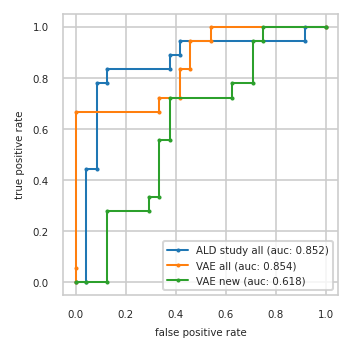

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.042 0.000
2          0.042 0.444   0.000 0.667   0.125 0.000
3          0.083 0.444   0.333 0.667   0.125 0.278
4          0.083 0.778   0.333 0.722   0.292 0.278
5          0.125 0.778   0.417 0.722   0.292 0.333
6          0.125 0.833   0.417 0.833   0.333 0.333
7          0.375 0.833   0.458 0.833   0.333 0.556
8          0.375 0.889   0.458 0.944   0.375 0.556
9          0.417 0.889   0.542 0.944   0.375 0.722
10         0.417 0.944   0.542 1.000   0.625 0.722
11         0.917 0.944   1.000 1.000   0.625 0.778
12         0.917 1.000     NaN   NaN   0.708 0.778
13         1.000 1.000     NaN   NaN   0.708 0.944
14           NaN   NaN     NaN   NaN   0.750 0.944
15           NaN   NaN     NaN   NaN   0.750 1.000
16           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,B4DGQ7;P21860;P21860-4,P51688
2,P09486,E7EUF1;Q13822-3,A0A087WXB8;Q9Y274
3,K7ERG9;P00746,P04075,O95297;O95297-2;O95297-3;O95297-4;Q9UEL6
4,P14174,C9JF17;P05090,P31321
5,P10636-2;P10636-6,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
6,P61981,Q9Y2T3;Q9Y2T3-3,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
7,Q6EMK4,P63104,Q96GD0
8,Q9Y2T3;Q9Y2T3-3,Q14894,P31150


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


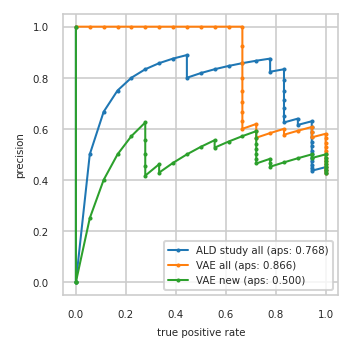

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.436 0.944     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.469 0.833
11         0.548 0.944     0.581 1.000     0.452 0.778
12         0.567 0.944     0.567 0.944     0.467 0.778
13         0.586 0.944     0.586 0.944     0.483 0.778
14         0.607 0.944     0.607 0.944     0.464 0.722
15         0.630 0.944     0.593 0.889     0.481 0.722
16         0.615 0.889     0.577 0.833     0.500 0.722
17         0.640 0.889     0.600 0.833     0.520 0.722
18         0.625 0.833     0.583 0.778     0.542 0.722
19         0.652 0.833     0.565 0.722     0.565 0.722
20         0.682 0.833     0.591 0.722     0.591 0.722
21         0.714 0.833     0.619 0.722     0.571 0.667
22         0.750 0.833     0.600 0.667     0.550 0.611
23         0.789 0.833     0.632 0.667     0.526 0.556
24         0.833 0.833     0.667 0.667     0.556 0.556
25         0.824 0.778     0.706 0.667     0.529 0.500
26         0.875 0.778     0.750 0.667     0.500 0.444
27         0.867 0.722     0.800 0.667     0.467 0.389
28         0.857 0.667     0.857 0.667     0.429 0.333
29         0.846 0.611     0.923 0.667     0.462 0.333
30         0.833 0.556     1.000 0.667     0.417 0.278
31         0.818 0.500     1.000 0.611     0.455 0.278
32         0.800 0.444     1.000 0.556     0.500 0.278
33         0.889 0.444     1.000 0.500     0.556 0.278
34         0.875 0.389     1.000 0.444     0.625 0.278
35         0.857 0.333     1.000 0.389     0.571 0.222
36         0.833 0.278     1.000 0.333     0.500 0.167
37         0.800 0.222     1.000 0.278     0.400 0.111
38         0.750 0.167     1.000 0.222     0.250 0.056
39         0.667 0.111     1.000 0.167     0.000 0.000
40         0.500 0.056     1.000 0.111     0.000 0.000
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


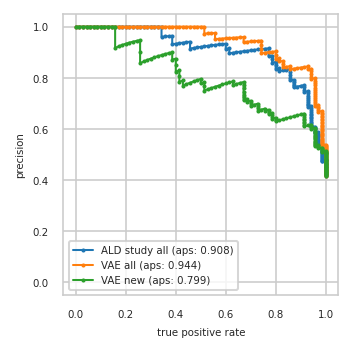

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


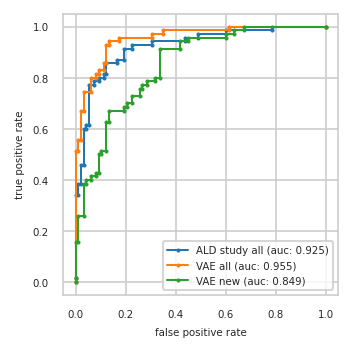

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}